In [1]:
#this cell handles each image by hand and does over multiple convolutions to try to better smooth the data
#also attempts to correct any units issues

from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


# In[4]:

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('../../imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using
    #print(low_res_name)
    #print(cols_str)
    #print([i in low_res_name for i in cols_str])
    #print(np.where([i in low_res_name for i in cols_str]))
    #sys.exit()
    
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns
        
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)
        
    if kern == 'box':
        kernel = Box2DKernel(16.)
    hdu_conv = convolve(hdu_dat, kernel)

    return hdu_conv
'''
idea from chris to speed up:
sq_avg_k = 1/9 * np.array([[1,1,1], [1,1,1], [1,1,1]])

im_blur = fftconvolve(image, sq_avg_k)

plt.imshow(im_blur)
plt.show()
'''



# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



# In[21]:

#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer
path = '../../../ngc1333_fits/'
im_names_hub_dash = im_name_finder(path+'*', 'fit')
im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'672_image.fits',
                path+'halph_hart_image.fits']


# names_arr = [(im_names_hub[2],im_names_hub_dash[4]), (im_names_hub[1],im_names_hub_dash[2]), 
#               (im_names_hub_dash[6],im_names_hub_dash[6]), (im_names_hub[1],im_names_hub_dash[2])]
names_arr = [(im_names_hub_dash[1], im_names_hub_dash[0]),
            (im_names_hub_dash[3],im_names_hub_dash[2]), (im_names_hub_dash[5],im_names_hub_dash[4]), 
             (im_names_hub_dash[6],im_names_hub_dash[6]), (im_names_hub_dash[7],im_names_hub_dash[7])]

#The output from im names hub ['../HH12_Hubble/HH6_126.fits', '../HH12_Hubble/128_image.fits', '../HH12_Hubble/126build_shift_2_drz.fits', '../HH12_Hubble/HH6_164.fits', '../HH12_Hubble/126_image.fits', '../HH12_Hubble/164_image.fits', '../HH12_Hubble/164build_shift_2_drz.fits', '../HH12_Hubble/128build_shift_2_drz.fits', '../HH12_Hubble/HH6_128.fits']
#or on local it's ['../../../ngc1333_fits/126_image.fits', '../../../ngc1333_fits/128_image.fits', '../../../ngc1333_fits/164_image.fits']
#print(im_names_hub_dash)...that's on the ssh computer...
#on local machine it's like # print(im_names_hub_dash); print(names_arr); print(im_names_hub)


# In[28]:

#Minimal loop through all the images, including a try/except in case an image is faulty for whatever reason
#IMPORTANT: A more detailed example between two single images is at the end of this code with many more comments

#First, we need to setup the image we're projecting ONTO
#This will be the same no matter the loop, so only need to do this once
#low_res = [x for x in im_names_spitz if 'n1333_lh_3_SiII_' in x][0]  #finding the lowest res image - LH and long lambda, so [SiII]
#hdu1 = fits.open(low_res)[0]
low_res = names_arr[0][1]   #Could also let this be a hubble image...if so, see the hubble loop below for how to setup grabbing the data, header, pixel conversion from the hdu
hdu1 = fits.open(low_res)

#hdu1_pix = hdu1.header['CDELT2'] #the pixel size in degrees, CDELT is the keyword for Spitzer images
#hdu1_pix_torad = hdu1_pix * np.pi / 180.
hdu1_pix = hdu1[0].header['D001SCAL'] #pixel size in arcsec, but D001SCAL is the keyword for Hubble images
hdu1_pix_torad = hdu1_pix / 206265.
hdu1_fnu = hdu1[0].header['PHOTFNU']
hdu1_flam = hdu1[0].header['PHOTFLAM']
hdu1_bw = hdu1[0].header['PHOTBW']

low_res = names_arr[0][0]
hdu1 = fits.open(low_res) #reading data
hdu1_data = hdu1[0].data
hdu1_header = hdu1[0].header
throughput1 = 0.496


'''
reading in the rest of the files...
'''

'''
for name, name2 in [(im_names_hub[2],im_names_hub_dash[4]), (im_names_hub[1],im_names_hub_dash[2]), (im_names_hub_dash[6],im_names_hub_dash[6])]:
    hdu2 = fits.open(name2)
#     try:
    #reading in data
    hdu2_pix = hdu2[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
    hdu2_pix_torad = hdu2_pix / 206265.
    
    
    if name != '../../../ngc1333_fits/halph_hart_image.fits':
        hdu2_fnu = hdu2[0].header['PHOTFNU']
        hdu2 = fits.open(name)
        
        hdu2_data = hdu2[0].data
        hdu2_header = hdu2[0].header
    else:
        hdu2 = fits.open(name)
        hdu2_fnu = hdu2[1].header['PHOTFNU']
        
        hdu2_data = hdu2[1].data
        hdu2_header = hdu2[1].header
        
'''
#128
name3, name4 = names_arr[1]  #reading in names
hdu3 = fits.open(name4)

#reading in conversions
hdu3_pix = hdu3[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu3_pix_torad = hdu3_pix / 206265.
hdu3_fnu = hdu3[0].header['PHOTFNU']
hdu3_flam = hdu3[0].header['PHOTFLAM']
hdu3_bw = hdu3[0].header['PHOTBW']

hdu3 = fits.open(name3)  #reading in data...
hdu3_data = hdu3[0].data
hdu3_header = hdu3[0].header
throughput3 = 0.521
    


#164
name, name2 = names_arr[2]  #reading in names
hdu2 = fits.open(name2)

#reading in conversions
hdu2_pix = hdu2[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu2_pix_torad = hdu2_pix / 206265.
hdu2_fnu = hdu2[0].header['PHOTFNU']
hdu2_flam = hdu2[0].header['PHOTFLAM']
hdu2_bw = hdu2[0].header['PHOTBW']

hdu2 = fits.open(name)  #reading in data...
hdu2_data = hdu2[0].data
hdu2_header = hdu2[0].header
throughput2 = 0.470




#672:
name7, name8 = names_arr[3]  #reading in names
hdu5 = fits.open('../../../ngc1333_fits/unregridded/0501_flt.fits')

#reading in conversions
hdu5_pix = hdu5[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu5_pix_torad = hdu5_pix / 206265.
hdu5_fnu = hdu5[1].header['PHOTFNU']
hdu5_flam = 1.3699E-17 # hdu5[1].header['PHOTFLAM']
hdu5_bw = 69.98 # hdu5[1].header['PHOTBW']

hdu5 = fits.open(name7) #reading in data...
hdu5_data = hdu5[0].data
hdu5_header = hdu5[0].header
throughput5 = 0.246




#'../../../ngc1333_fits/halph_hart_image.fits':
name5, name6 = names_arr[4]  #reading in names
hdu4 = fits.open('../../../ngc1333_fits/unregridded/halph_hart_image.fits')

#reading in conversions
hdu4_pix = hdu4[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
hdu4_pix_torad = hdu4_pix / 206265.
hdu4_fnu = hdu4[1].header['PHOTFNU']
hdu4_flam = hdu4[1].header['PHOTFLAM']
hdu4_bw = hdu4[1].header['PHOTBW']

hdu4 = fits.open(name5) #reading in data...
hdu4_data = hdu4[0].data
hdu4_header = hdu4[0].header
throughput4 = 0.242


'''
need to do mutual convolutions
'''

#convolving images
res_str = '_flam'
# resize = 60. #if trying to adjust size of gaussian convolution
D = 2.4 #/ resize #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

#do with own psf
hdu1_conv = im_conv(low_res, D, hdu1_pix_torad, hdu1_data, 'gauss')
hdu2_conv = im_conv(name, D, hdu2_pix_torad, hdu2_data, 'gauss')
hdu3_conv = im_conv(name3, D, hdu3_pix_torad, hdu3_data, 'gauss')
hdu4_conv = im_conv(name5, D, hdu4_pix_torad, hdu4_data, 'gauss')
hdu5_conv = im_conv(name7, D, hdu5_pix_torad, hdu5_data, 'gauss')

# #1 and 2
hdu1_conv = im_conv(name, D, hdu2_pix_torad, hdu1_conv, 'gauss')
hdu2_conv = im_conv(low_res, D, hdu1_pix_torad, hdu2_conv, 'gauss')

# #3 and 4
hdu3_conv = im_conv(name4, D, hdu4_pix_torad, hdu3_conv, 'gauss')
hdu4_conv = im_conv(name3, D, hdu3_pix_torad, hdu4_conv, 'gauss')

# #1 and 3
hdu1_conv = im_conv(name3, D, hdu3_pix_torad, hdu1_conv, 'gauss')
hdu3_conv = im_conv(low_res, D, hdu1_pix_torad, hdu3_conv, 'gauss')

# #2 and 4
hdu2_conv = im_conv(name5, D, hdu4_pix_torad, hdu2_conv, 'gauss')
hdu4_conv = im_conv(name3, D, hdu2_pix_torad, hdu4_conv, 'gauss')

#5 with one of them that's been convolved with all the others
hdu2_conv = im_conv(name7, D, hdu5_pix_torad, hdu2_conv, 'gauss')
hdu3_conv = im_conv(name7, D, hdu5_pix_torad, hdu3_conv, 'gauss')
hdu4_conv = im_conv(name7, D, hdu5_pix_torad, hdu4_conv, 'gauss')
hdu5_conv = im_conv(low_res, D, hdu1_pix_torad, hdu5_conv, 'gauss')
hdu1_conv = im_conv(name7, D, hdu5_pix_torad, hdu1_conv, 'gauss')

    
'''
onto converting units and regridding...
'''
    
    
#converting the convolved image to correct units and saving it so we can reproject it
#conversion needed for hubble case since units are not in terms of surface brightness
hdu1_conv_scaled = hdu1_conv
hdu1_conv_scaled = hdu1_conv_scaled * hdu1_flam #converting to flambda units
hdu1_conv_scaled = hdu1_conv_scaled * throughput1 * hdu1_bw #since all the images are per throughput
# hdu1_conv_scaled = hdu1_conv_scaled * hdu1_fnu / 1e6 #converting to MJy
hdu1_conv_scaled = hdu1_conv_scaled / hdu1_pix_torad**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec

hdu2_conv_scaled = hdu2_conv
hdu2_conv_scaled = hdu2_conv_scaled * hdu2_flam #converting to flambda units
hdu2_conv_scaled = hdu2_conv_scaled * throughput2 * hdu2_bw #since all the images are per throughput
# hdu2_conv_scaled = hdu2_conv_scaled * hdu2_fnu / 1e6 #converting to MJy
hdu2_conv_scaled = hdu2_conv_scaled / hdu2_pix_torad**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec

hdu3_conv_scaled = hdu3_conv
hdu3_conv_scaled = hdu3_conv_scaled * hdu3_flam #converting to flambda units
hdu3_conv_scaled = hdu3_conv_scaled * throughput3 * hdu3_bw #since all the images are per throughput
# hdu3_conv_scaled = hdu3_conv_scaled * hdu3_fnu / 1e6 #converting to MJy
hdu3_conv_scaled = hdu3_conv_scaled / hdu3_pix_torad**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec

hdu4_conv_scaled = hdu4_conv
hdu4_conv_scaled = hdu4_conv_scaled * hdu4_flam #converting to flambda units
hdu4_conv_scaled = hdu4_conv_scaled * throughput4 * hdu4_bw #since all the images are per throughput
# hdu4_conv_scaled = hdu4_conv_scaled * hdu4_fnu / 1e6 #converting to MJy
hdu4_conv_scaled = hdu4_conv_scaled / hdu4_pix_torad**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec

hdu5_conv_scaled = hdu5_conv
hdu5_conv_scaled = hdu5_conv_scaled * hdu5_flam #converting to flambda units
hdu5_conv_scaled = hdu5_conv_scaled * throughput5 * hdu5_bw #since all the images are per throughput
# hdu5_conv_scaled = hdu5_conv_scaled * hdu5_fnu / 1e6 #converting to MJy
hdu5_conv_scaled = hdu5_conv_scaled / hdu5_pix_torad**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec




#you'll need to set the WCS to be that of the header you're basing this off of...ie the header
# hdu1_conv_scaled = im_conv(name, D, hdu2_pix_torad, hdu1_conv_scaled, 'box')   #applying convolution to the image I'm regridding to immediately
hdu1_conv_scaled =  hdu1_conv_scaled * hdu1_pix_torad**2.

w1 = WCS(hdu1_header)
wcs_header1 = w1.to_header()
file_start = '../../Convolved_Images_Hub/conv_'+res_str+'_'
conv1_path = fits_saver(hdu1_conv_scaled, wcs_header1, low_res, file_start)

w2 = WCS(hdu2_header)
wcs_header2 = w2.to_header()
conv2_path = fits_saver(hdu2_conv_scaled, wcs_header2, name, file_start)
    
w3 = WCS(hdu3_header)
wcs_header3 = w3.to_header()
conv3_path = fits_saver(hdu3_conv_scaled, wcs_header3, name3, file_start)

w4 = WCS(hdu4_header)
wcs_header4 = w4.to_header()
conv4_path = fits_saver(hdu4_conv_scaled, wcs_header4, name5, file_start)

w5 = WCS(hdu5_header)
wcs_header5 = w5.to_header()
conv5_path = fits_saver(hdu5_conv_scaled, wcs_header5, name7, file_start)


#reprojection of one hdu using the header (coords and pixels) of another
#The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
#para is False for large images (like these hubble ones)
#output is array (a 2D array of data) and footprint (the footprint from the analysis)
para = False
array, footprint = reproject_exact(conv2_path, w1, shape_out=hdu1_conv_scaled.shape, parallel=para)
array2, footprint2 = reproject_exact(conv3_path, w1, shape_out=hdu1_conv_scaled.shape, parallel=para)
array3, footprint3 = reproject_exact(conv4_path, w1, shape_out=hdu1_conv_scaled.shape, parallel=para)
array4, footprint4 = reproject_exact(conv5_path, w1, shape_out=hdu1_conv_scaled.shape, parallel=para)

array = array * hdu2_pix_torad**2.
array2 = array2 * hdu3_pix_torad**2.
array3 = array3 * hdu4_pix_torad**2.
array4 = array4 * hdu5_pix_torad**2.


#now that we have a reprojected hubble image for hdu2 and both are convolved, need to
#divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!
#data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

#if box is used NEED TO REMEMBER TO COMMENT OUT PIXEL CONVERSION ABOVE...as it would be done here?
#reconvolving to a new resolution...note all the other parameters don't matter if box is used, only the data matters
# array = im_conv(name, D, hdu2_pix_torad, array, 'box') #* hdu2_pix_torad**2.
# array2 = im_conv(name3, D, hdu3_pix_torad, array2, 'box') #* hdu3_pix_torad**2.
# array3 = im_conv(name5, D, hdu4_pix_torad, array3, 'box') #* hdu4_pix_torad**2.
# array4 = im_conv(name7, D, hdu5_pix_torad, array4, 'box') #* hdu5_pix_torad**2.
    
    
    
#saving a new fits file from the reprojected image
#first, grabbing the WCS coords of the appropriate image to be set as the header of the new image
# remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
#w = WCS(hdu1_header)
#wcs_header = w.to_header()
#save_path = 'Regridded_Hub/regrid_'  #See fits_saver's "save_path" description for explanation
#fits_saver(data_ratio, wcs_header, 'hub_fe_ratio.fits', save_path)  #saving the reprojected image

w = WCS(hdu1_header)
wcs_header = w.to_header()
file_start = '../../Regridded_Hub/regrid_'+res_str+'_'
regrid_2_path = fits_saver(array, wcs_header, name, file_start)
regrid_2_foot_path = fits_saver(footprint, wcs_header, name, file_start+'_footprint_')

regrid_3_path = fits_saver(array2, wcs_header, name3, file_start)
regrid_3_foot_path = fits_saver(footprint2, wcs_header, name3, file_start+'_footprint_')

regrid_4_path = fits_saver(array3, wcs_header, name5, file_start)
regrid_4_foot_path = fits_saver(footprint3, wcs_header, name5, file_start+'_footprint_')

regrid_5_path = fits_saver(array4, wcs_header, name7, file_start)
regrid_5_foot_path = fits_saver(footprint4, wcs_header, name7, file_start+'_footprint_')

#     except Exception as e: print(e, name)

sys.exit()

                                                                                                                     

3.7.4


SystemExit: 

C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


SystemExit: 

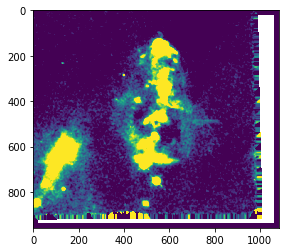

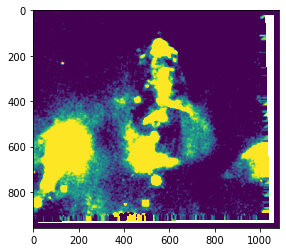

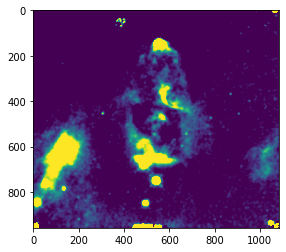

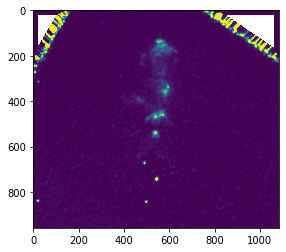

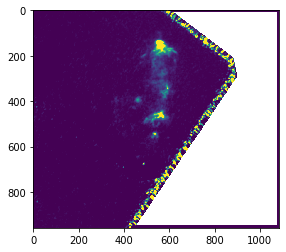

In [58]:
# plt.figure()
# plt.imshow(hdu1_conv_scaled, vmin=0, vmax=1e-17)
# plt.figure()
# plt.imshow(array, vmin=0, vmax=1e-17)
# plt.figure()
# plt.imshow(array2, vmin=0, vmax=1e-17)
# plt.figure()
# plt.imshow(array3, vmin=0, vmax=1e-17)
# plt.figure()
# plt.imshow(array4, vmin=0, vmax=1e-17)

# sys.exit()

#background subtraction
noise_126 = 2.6e-18 #* 0.496 #  0.216037 / 4.25e10 #times by throughput
noise_128 = 2.75e-18 #* 0.521 # 0.258513 / 4.25e10 #times by throughput
noise_164 = 5.766e-18  #* 0.470 # 0.39321 / 4.25e10 #times by throughput
noise_halpha = 4.4e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs
noise_672 = 4.4e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs


#based on https://stackoverflow.com/questions/7997152/python-3d-polynomial-surface-fit-order-dependent
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

def main():
    # Generate Data...
    numdata = 100
    x = np.random.random(numdata)
    y = np.random.random(numdata)
    z = x**2 + y**2 + 3*x**3 + y + np.random.random(numdata)

    # Fit a 3rd order, 2d polynomial
    m = polyfit2d(x,y,z)

    # Evaluate it on a grid...
    nx, ny = 20, 20
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                         np.linspace(y.min(), y.max(), ny))
    zz = polyval2d(xx, yy, m)

    # Plot
    plt.imshow(zz, extent=(x.min(), y.max(), x.max(), y.min()))
    plt.scatter(x, y, c=z)
    plt.show()
main()



In [6]:
where_are_NaNs = np.isnan(array)
array[where_are_NaNs] = 0.

where_are_NaNs = np.isnan(array2)
array2[where_are_NaNs] = 0.

where_are_NaNs = np.isnan(array3)
array3[where_are_NaNs] = 0.

where_are_NaNs = np.isnan(hdu1_conv_scaled)
hdu1_conv_scaled[where_are_NaNs] = 0.


print(np.max(hdu1_conv_scaled))
print(np.max(array))
print(np.max(array2))
print(np.max(array3))

4.210663874789214e-15
3.722028595378417e-15
1.0722416652146785e-14
1.1699887324590845e-15


In [4]:
np.savetxt('data_arrs/f126_data.txt', hdu1_conv_scaled)
np.savetxt('data_arrs/f164_data.txt', array)
np.savetxt('data_arrs/f128_data.txt', array2)
np.savetxt('data_arrs/f656_data.txt', array3)

In [ ]:
from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


# In[4]:

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(low_res_name, D, hdu1_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('../../imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using
    #print(low_res_name)
    #print(cols_str)
    #print([i in low_res_name for i in cols_str])
    #print(np.where([i in low_res_name for i in cols_str]))
    #sys.exit()
    
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu1_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)
        
    if kern == 'box':
        kernel = Box2DKernel(16.)
    hdu_conv = convolve(hdu_dat, kernel)

    return hdu_conv
'''
idea from chris to speed up:
sq_avg_k = 1/9 * np.array([[1,1,1], [1,1,1], [1,1,1]])

im_blur = fftconvolve(image, sq_avg_k)

plt.imshow(im_blur)
plt.show()
'''



# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



# In[21]:

#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer
path = '../../../ngc1333_fits/'
im_names_hub_dash = im_name_finder(path+'*', 'fit')
im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits']

#The output from im names hub ['../HH12_Hubble/HH6_126.fits', '../HH12_Hubble/128_image.fits', '../HH12_Hubble/126build_shift_2_drz.fits', '../HH12_Hubble/HH6_164.fits', '../HH12_Hubble/126_image.fits', '../HH12_Hubble/164_image.fits', '../HH12_Hubble/164build_shift_2_drz.fits', '../HH12_Hubble/128build_shift_2_drz.fits', '../HH12_Hubble/HH6_128.fits']
#or on local it's ['../../../ngc1333_fits/126_image.fits', '../../../ngc1333_fits/128_image.fits', '../../../ngc1333_fits/164_image.fits']
#print(im_names_hub_dash)...that's on the ssh computer...
#on local machine it's like # ['../../../ngc1333_fits/126build_shift_2_drz.fits', '../../../ngc1333_fits/126_image.fits', 
# '../../../ngc1333_fits/128build_shift_2_drz.fits', '../../../ngc1333_fits/128_image.fits', 
# '../../../ngc1333_fits/164build_shift_2_drz.fits', '../../../ngc1333_fits/164_image.fits', 
# '../../../ngc1333_fits/halph_hart_image.fits', '../../../ngc1333_fits/url_saver.py']




# In[28]:

#Minimal loop through all the images, including a try/except in case an image is faulty for whatever reason
#IMPORTANT: A more detailed example between two single images is at the end of this code with many more comments

#First, we need to setup the image we're projecting ONTO
#This will be the same no matter the loop, so only need to do this once
#low_res = [x for x in im_names_spitz if 'n1333_lh_3_SiII_' in x][0]  #finding the lowest res image - LH and long lambda, so [SiII]
#hdu1 = fits.open(low_res)[0]
low_res = im_names_hub_dash[0]   #Could also let this be a hubble image...if so, see the hubble loop below for how to setup grabbing the data, header, pixel conversion from the hdu
hdu1 = fits.open(low_res)

#hdu1_pix = hdu1.header['CDELT2'] #the pixel size in degrees, CDELT is the keyword for Spitzer images
#hdu1_pix_torad = hdu1_pix * np.pi / 180.
hdu1_pix = hdu1[0].header['D001SCAL'] #pixel size in arcsec, but D001SCAL is the keyword for Hubble images
hdu1_pix_torad = hdu1_pix / 206265.
hdu1_fnu = hdu1[0].header['PHOTFNU']

low_res = im_names_hub[0]
hdu1 = fits.open(low_res)
hdu1_data = hdu1[0].data
hdu1_header = hdu1[0].header




for name, name2 in [(im_names_hub[2],im_names_hub_dash[4]), (im_names_hub[1],im_names_hub_dash[2]), (im_names_hub_dash[6],im_names_hub_dash[6])]:
    hdu2 = fits.open(name2)
#     try:
    #reading in data
    hdu2_pix = hdu2[0].header['D001SCAL'] #same as above line, but D001SCAL is the keyword for Hubble images
    hdu2_pix_torad = hdu2_pix / 206265.
    
    
    if name != '../../../ngc1333_fits/halph_hart_image.fits':
        hdu2_fnu = hdu2[0].header['PHOTFNU']
        hdu2 = fits.open(name)
        
        hdu2_data = hdu2[0].data
        hdu2_header = hdu2[0].header
    else:
        hdu2 = fits.open(name)
        hdu2_fnu = hdu2[1].header['PHOTFNU']
        
        hdu2_data = hdu2[1].data
        hdu2_header = hdu2[1].header
        

        
    #convolving images
    resize = 60.
    res_str = '16'
    D = 2.4 / resize #that of Hubble, in m
    D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file
    
    hdu1_conv = im_conv(name, D, hdu2_pix_torad, hdu1_data)
    hdu2_conv = im_conv(low_res, D, hdu1_pix_torad, hdu2_data)

    #converting the convolved image to correct units and saving it so we can reproject it
    #conversion needed for hubble case since units are not in terms of surface brightness
    hdu1_conv_scaled = hdu1_conv
    hdu1_conv_scaled = hdu1_conv_scaled * hdu1_fnu / 1e6 #converting to MJy
    hdu1_conv_scaled = hdu1_conv_scaled / hdu1_pix**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec

    hdu2_conv_scaled = hdu2_conv
    hdu2_conv_scaled = hdu2_conv_scaled * hdu2_fnu / 1e6 #converting to MJy
    hdu2_conv_scaled = hdu2_conv_scaled / hdu2_pix**2. #* 4.25e10 #dividing out sr, D001SCAL is key for pixel size in arcsec


    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
    w = WCS(hdu1_header)
    wcs_header = w.to_header()
    file_start = '../../Convolved_Images_Hub/conv_box'+res_str+'_'
    conv1_path = fits_saver(hdu1_conv_scaled, wcs_header, low_res, file_start)
    
    w = WCS(hdu2_header)
    wcs_header = w.to_header()
    file_start = '../../Convolved_Images_Hub/conv_box'+res_str+'_'
    conv2_path = fits_saver(hdu2_conv_scaled, wcs_header, name, file_start)
    


    #reprojection of one hdu using the header (coords and pixels) of another
    #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #para is False for large images (like these hubble ones)
    #output is array (a 2D array of data) and footprint (the footprint from the analysis)
    para = False
    array, footprint = reproject_exact(conv2_path, w, shape_out=hdu1_conv_scaled.shape, parallel=para)

    #now that we have a reprojected hubble image for hdu2 and both are convolved, need to
    #divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!
    #data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

    
    #reconvolving to a new resolution...
    hdu1_conv = im_conv(name, D, hdu2_pix_torad, hdu1_data)
    hdu2_conv = im_conv(low_res, D, hdu1_pix_torad, hdu2_data)
    

    #saving a new fits file from the reprojected image
    #first, grabbing the WCS coords of the appropriate image to be set as the header of the new image
    # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
    #w = WCS(hdu1_header)
    #wcs_header = w.to_header()
    #save_path = 'Regridded_Hub/regrid_'  #See fits_saver's "save_path" description for explanation
    #fits_saver(data_ratio, wcs_header, 'hub_fe_ratio.fits', save_path)  #saving the reprojected image
    
    w = WCS(hdu1_header)
    wcs_header = w.to_header()
    file_start = '../../Regridded_Hub/regrid_box'+res_str+'_'
    regrid_2_path = fits_saver(array, wcs_header, name, file_start)
    regrid_2_foot_path = fits_saver(footprint, wcs_header, name, file_start+'footprint_box'+res_str+'_')

#     except Exception as e: print(e, name)

sys.exit()

                                                                                                                     

In [ ]:
#functions to set up cropping and viewing images in python
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u

def imcrop(mylon, mylat, xsize, ysize, im, w):
    # example coordinate - you'll have to figure one out that's in your map
    center = coordinates.SkyCoord(mylon*u.deg, mylat*u.deg, frame='fk5')

    # then make an array cutout
    co = nddata.Cutout2D(im, center, size=[ysize, xsize]*u.deg, wcs=w)

    return co.data, co.wcs#making cutout of image...based on https://stackoverflow.com/questions/33512681/splicing-image-array-fits-file-using-coordinates-from-header


import matplotlib.pyplot as plt

def implot(data, w, wcscond):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=1)
    plt.xlabel('RA')
    plt.ylabel('Dec')

In [ ]:
#testing cropping and plotting functions

#only saving the fits files
import glob
filenames = glob.glob('../../../ngc1333_fits/*image.fits')
print(filenames)

#handling image ^@^@^@^@data
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D


for file in filenames:
    hdu1 = fits.open(file)  #import image
    w = wcs.WCS(hdu1[1].header)   #get wcs coords
#     print(w.array_shape)
#     w = wcs.utils.wcs_to_celestial_frame(w)
    
    #following idea about slices from https://joseph-long.com/writing/from-sky-coordinates-to-pixels-and-back/
    ymin_int = 2750
    ymax_int = 3000
    xmin_int = 4550
    xmax_int = 4900
    slices = (slice(ymin_int, ymax_int), slice(xmin_int, xmax_int))
    
        #implementing slices method...doesn't seem to work for wcs
    #     data = hdu1[1].data[1000:4000, 1000:7000]    #grab data
#     data = hdu1[1].data[ymin_int:ymax_int, xmin_int:xmax_int]    #grab data    
#     data = hdu1[1].data[slices]
#     new_wcs = w.slice(slices)
    
    #cuting out data and wcs
    data = hdu1[1].data
    
    position = (4725, 2875)  #x, y!
#     position = wcs.utils.pixel_to_skycoord(position[0], position[1], w) #converting to sky coords!
    size = (240, 300)  #y, x!...necessary b/c of how cutout works
#     sizexy = wcs.utils.pixel_to_skycoord(size[1], size[0], w)
#     print(sizexy)
#     size= [sizexy[1], sizexy[0]]
    
    cutout = Cutout2D(data, position, size, wcs = w.celestial)
    datacut = cutout.data
    wcscut = cutout.wcs 
#     print(wcscut.is_celestial)
    
    #updating header with WCS info
    newhead = hdu1[0].header.update(wcscut.to_header())
    hdu1.close()

    #plotting
    implot(datacut, wcscut)  
#     implot(data, new_wcs)     #plot
#     plt.savefig('datacut.png')
#     sys.exit()

    
    #saving full fits file...
    lamnum = file[file.index('build')-3:file.index('build')]
    fits.writeto('HH6_'+lamnum+".fits", datacut, wcscut.to_header(), overwrite=True)
#     fits.writeto('HH6_'+lamnum+".fits", datacut, newhead, overwrite=True)

#     output_hdul = new_wcs.to_fits()
#     output_hdul[0].data = data
#     output_hdul.writeto('HH6_'+file[:3]+".fits", overwrite=True)
#     sys.exit()

